<a href="https://colab.research.google.com/github/Crazytiger0527/Study_Pytorch/blob/main/RNN%2CLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd/content/drive/MyDrive/deeplearningbro/deeplearningbro/pytorch

/content/drive/MyDrive/deeplearningbro/deeplearningbro/pytorch


In [5]:
df = pd.read_csv("./data/kospi.csv")

In [6]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,2183.489990,2206.199951,2177.879883,2206.199951,2206.199951,480400
1,2019-01-31,2222.879883,2222.879883,2201.219971,2204.850098,2204.850098,545200
2,2019-02-01,2211.929932,2218.780029,2201.409912,2203.459961,2203.459961,479400
3,2019-02-07,2215.770020,2215.790039,2196.770020,2203.419922,2203.419922,427800
4,2019-02-08,2192.010010,2192.479980,2171.959961,2177.050049,2177.050049,391000


In [7]:
scaler = MinMaxScaler()   # 0~1사이로 만들기
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Volume']])

In [8]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,0.722898,0.732351,0.745525,0.759235,2206.199951,0.242113
1,2019-01-31,0.763058,0.750069,0.769089,0.757866,2204.850098,0.274771
2,2019-02-01,0.751894,0.745714,0.769280,0.756456,2203.459961,0.241609
3,2019-02-07,0.755809,0.742538,0.764596,0.756415,2203.419922,0.215603
4,2019-02-08,0.731584,0.717777,0.739548,0.729669,2177.050049,0.197057


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431 entries, 0 to 430
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       431 non-null    object 
 1   Open       431 non-null    float64
 2   High       431 non-null    float64
 3   Low        431 non-null    float64
 4   Close      431 non-null    float64
 5   Adj Close  431 non-null    float64
 6   Volume     431 non-null    float64
dtypes: float64(6), object(1)
memory usage: 23.7+ KB


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is avaliable')

cuda:0 is avaliable


In [11]:
X = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

In [12]:
def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  for i in range(len(x)-sequence_length):
    x_seq.append(x[i:i+sequence_length])
    y_seq.append(y[i+sequence_length])

  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1,1])

In [13]:
split = 200
sequence_length = 5

x_seq, y_seq = seq_data(X, y, sequence_length)
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

<ipython-input-12-5667cf850510>:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1,1])


torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([226, 5, 4]) torch.Size([226, 1])


In [14]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 20
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

In [15]:
# Hyperparameter 설정
# RNN
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [16]:
# 모델구축
class VanillaRNN(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)     
    self.fc = nn.Sequential(nn.Linear(hidden_size*sequence_length, 1), nn.Sigmoid())

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out, _ = self.rnn(x, h0)
    out = out.reshape(out.shape[0],-1)
    out = self.fc(out)
    return out  

In [17]:
model = VanillaRNN(input_size=input_size,
                   hidden_size=hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device = device).to(device)

In [18]:
criterion = nn.MSELoss()

lr = 1e-3
num_epochs = 200
optimizer = optim.Adam(model.parameters(), lr=lr)

In [19]:
loss_graph =[]
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0.0

  for data in train_loader:
    seq, target = data
    out = model(seq)
    loss = criterion(out, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  loss_graph.append(running_loss/n)
  if epoch%100 == 0:
    print("[epoch: %d loss: %.4f" % (epoch, running_loss/n))

[epoch: 0 loss: 0.0193
[epoch: 100 loss: 0.0012


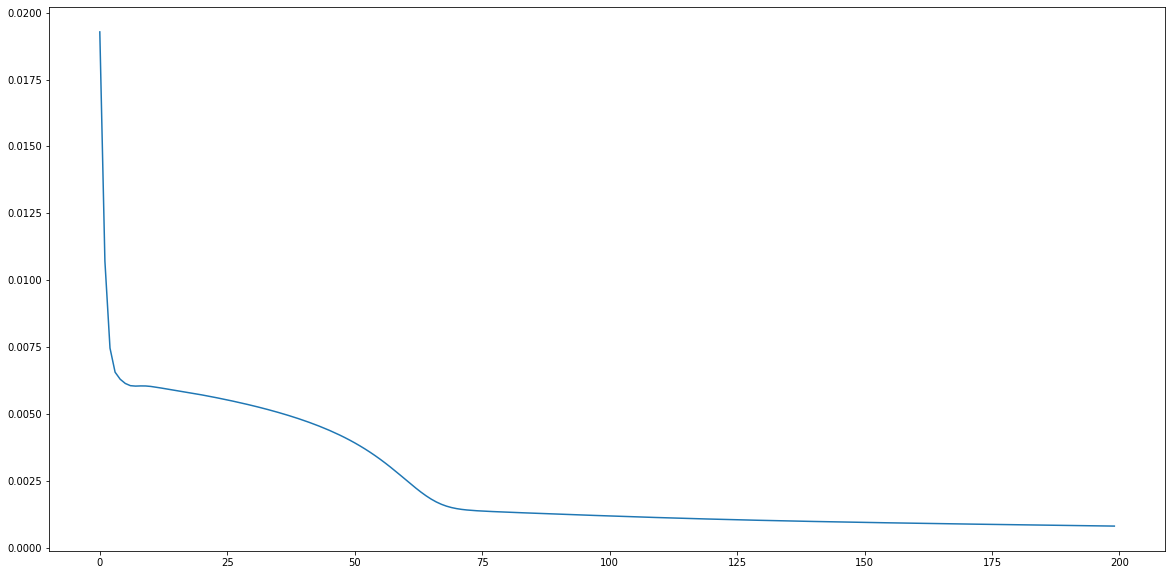

In [21]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

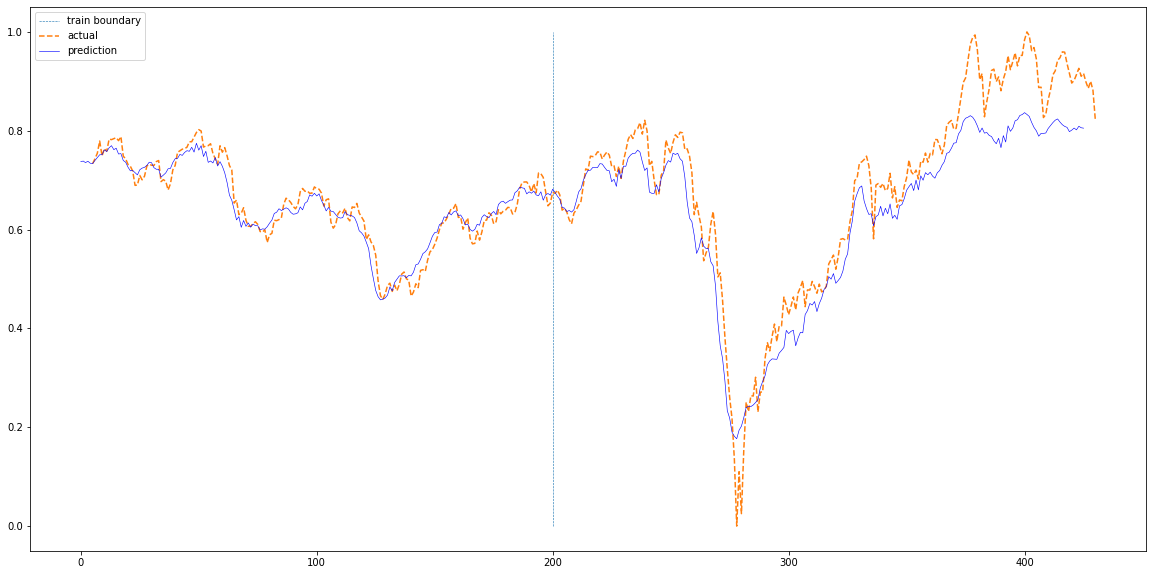

In [24]:
def plotting(train_loader, test_loader, actual):
  with torch.no_grad():
    train_pred = []
    test_pred = []

    for data in train_loader:
      seq, target = data
      out = model(seq)
      train_pred += out.cpu().numpy().tolist()

    for data in test_loader:
      seq, target = data
      out = model(seq)
      test_pred += out.cpu().numpy().tolist()
  total = train_pred+test_pred
  plt.figure(figsize=(20,10))
  plt.plot(np.ones(100)*len(train_pred),np.linspace(0,1,100),'--', linewidth=0.6)
  plt.plot(actual,'--')
  plt.plot(total,'b',linewidth=0.6)

  plt.legend(['train boundary', 'actual','prediction'])
  plt.show()
plotting(train_loader, test_loader, df['Close'][sequence_length:])


In [25]:
# 모델구축
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)     
    self.fc = nn.Sequential(nn.Linear(hidden_size*sequence_length, 1), nn.Sigmoid())

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    c0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
    out, _ = self.lstm(x, (h0,c0))
    out = out.reshape(out.shape[0],-1)
    out = self.fc(out)
    return out  

In [27]:
model = LSTM(input_size=input_size,
                   hidden_size=hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device = device).to(device)

In [28]:
criterion = nn.MSELoss()

lr = 1e-3
num_epochs = 200
optimizer = optim.Adam(model.parameters(), lr=lr)

In [29]:
loss_graph =[]
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0.0

  for data in train_loader:
    seq, target = data
    out = model(seq)
    loss = criterion(out, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  loss_graph.append(running_loss/n)
  if epoch%100 == 0:
    print("[epoch: %d loss: %.4f" % (epoch, running_loss/n))

[epoch: 0 loss: 0.0331
[epoch: 100 loss: 0.0012


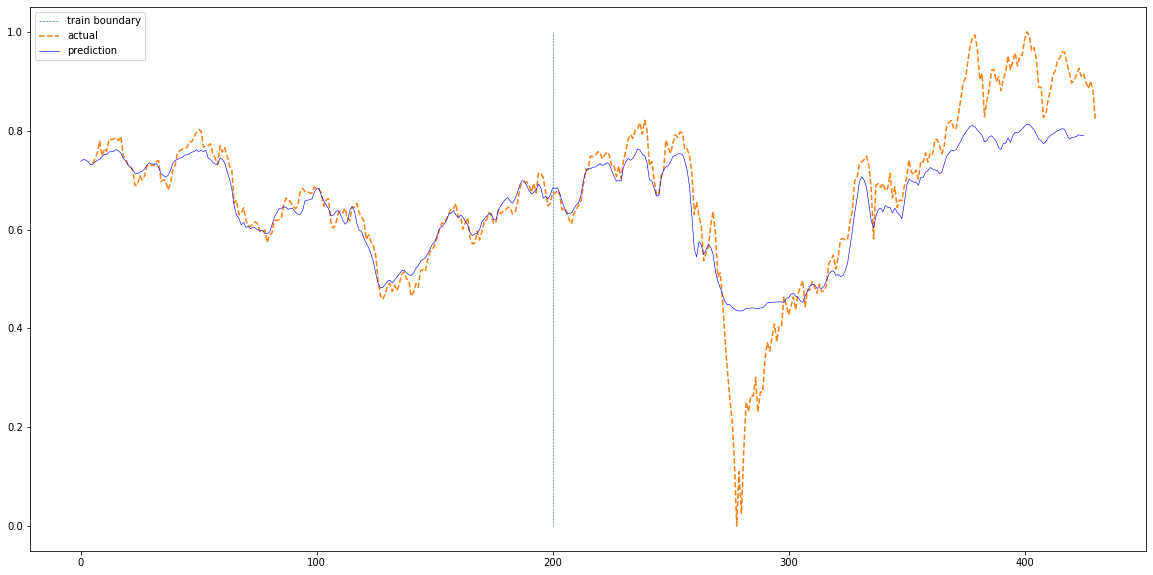

In [30]:
plotting(train_loader, test_loader, df['Close'][sequence_length:])